# **Dynamic Uncertainty Aware Divide2Conquer (DUA-D2C)**
This notebook contains the code and implementation details (for image classification using CIFAR-10 dataset in this case) on our proposed method, **Dynamic Uncertainty Aware Divide2Conquer (DUA-D2C)** to address the issue of **Overfitting** in Deep Learning models. We propose partitioning the training data into multiple subsets and training separate identical models on them. To avoid overfitting on any specific subset, the trained parameters from these models are aggregated and scaled periodically throughout the training phase, enabling the model to learn from the entire dataset while mitigating the impact of individual outliers or noise.

## **Importing Necessary Packages & Mounting Drive**

In [ ]:
# Install CUDA 11.8
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
!mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/3bf863cc.pub
!add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/ /"
!apt-get update
!apt-get -y install cuda-11-8

# Install cuDNN 8.6 (for CUDA 11.x)
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.1-1_all.deb
!dpkg -i cuda-keyring_1.1-1_all.deb
!apt-get update
!apt-get install -y libcudnn8=8.6.0.*-1+cuda11.8
!apt-get install -y libcudnn8-dev=8.6.0.*-1+cuda11.8

--2025-05-05 17:18:18--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.210.244.141, 23.210.244.162
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.210.244.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu2204.pin’

cuda-ubuntu2204.pin 100%[===================>]     190  --.-KB/s    in 0s      

2025-05-05 17:18:18 (71.3 MB/s) - ‘cuda-ubuntu2204.pin’ saved [190/190]

Executing: /tmp/apt-key-gpghome.kDSA5LK0MO/gpg.1.sh --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/3bf863cc.pub
gpg: requesting key from 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/3bf863cc.pub'
gpg: key A4B469963BF863CC: public key "cudatools <cudatools@nvidia.com>" imported
gpg: Total number processed: 1
gpg:     

In [ ]:
# Uninstall existing TensorFlow (if any)
!pip uninstall tensorflow tensorflow-gpu -y

# Install TF 2.12.1 with GPU support
!pip install tensorflow==2.12.1


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 MB 23.9 MB/s eta 0:00:00
  Attempting uninstall:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import random
import cv2
import os
import sys
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, accuracy_score

sys.path.append('/content/drive/MyDrive/IAR Research Grant/Codes/Refined Codes')
from duad2c_utils import *
#tf.config.run_functions_eagerly(True)

## **Loading Dataset & Data Preprocessing**

In [ ]:
def load_cifar10(num_training=45000, num_validation=5000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test

# If there are errors with SSL downloading involving self-signed certificates,
# it may be that your Python version was recently installed on the current machine.
# See: https://github.com/tensorflow/tensorflow/issues/10779
# To fix, run the command: /Applications/Python\ 3.7/Install\ Certificates.command
#   ...replacing paths as necessary.

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170498071/170498071 [==============================] - 5s 0us/step
Train data shape:  (45000, 32, 32, 3)
Train labels shape:  (45000,) int32
Validation data shape:  (5000, 32, 32, 3)
Validation labels shape:  (5000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Data Preprocessing

In [ ]:
# Reshaping data
x_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
x_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
x_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
input_shape = (32, 32, 3)
num_classes = 10

# Normalizing data
X_train = x_train.astype('float32')
X_val = x_val.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255
X_val /= 255
X_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
5000 validation samples
10000 test samples


In [ ]:
#binarize the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.fit_transform(y_val)
y_test = lb.fit_transform(y_test)

# **Data Augmentation Setup**

In [ ]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
    )

## **Defining Necessary Functions**

In [ ]:
def create_subsets(image_list, label_list, num_subsets=3, initial='subset'):
    ''' return: a dictionary with keys subset names and value as
                data shards - tuple of sequence and label lists.
        args:
            image_list: a list of numpy arrays of inputs
            label_list:a list of binarized labels for each sequence
            num_subsets: number of training subsets
            initials: the subset name prefix, e.g, subset_1

    '''

    #create a list of subset no.
    subset_no = ['{}_{}'.format(initial, i+1) for i in range(num_subsets)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each subset
    size = len(data)//num_subsets
    shards = [data[i:i + size] for i in range(0, size*num_subsets, size)]

    #number of subsets must equal number of shards
    assert(len(shards) == len(subset_no))

    return {subset_no[i] : shards[i] for i in range(len(subset_no))}

In [ ]:
def batch_data(data_shard, bs=32):
    '''Takes in a subsets' data shard and creates a tfds object off it
    args:
        shard: a data, label constituting a subsets' data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [ ]:
def repeat_samples(arr, target_shape):
    # Calculate the number of times each sample should be repeated
    num_repeats = target_shape[0] // arr.shape[0]

    # Repeat each sample along the first axis
    repeated_arr = np.repeat(arr, num_repeats, axis=0)

    return repeated_arr

# **Setting Hyperparameter Values**
The new global hyperparameters that need tuning, in this case, are the **Number of Subsets of the Training Set** and the **Number of Epochs before each round of Global Averaging**. To refer to them concisely, we will use the variables **N** and **E** respectively.

In [ ]:
# Setting the Number of Subsets of the Training Set, N
N = 3

# Setting the Number of Epochs before each round of Global Averaging, E
E = 1

In [ ]:
#create subsets
subsets = create_subsets(X_train, y_train, num_subsets=N, initial='subset')

In [ ]:
#process and batch the training data for each subset
subsets_batched = dict()
for (subset_no, data) in subsets.items():
    subsets_batched[subset_no] = batch_data(data)

#process and batch the train set
train_batched = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(len(y_train))
#process and batch the validation set
val_batched = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(len(y_val))
#process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

# **Constructing the Deep Learning Model**

In [ ]:
class CNNModel:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.1))
        model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.3))
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        #model.add(Activation("softmax"))
        return model

In [ ]:
lr = 0.001
comms_round = 101 # Number of Global Epochs
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, epsilon=0.001, amsgrad=True)

Accu = []
Loss = []
Tr_Accu = []
Tr_Loss =[]

# **Training The Subset Models And Central Averaging**

# **DUA-D2C**

In [ ]:
# Initialize central model
mcnn_central = CNNModel()
central_model = mcnn_central.build((32, 32, 3), 10)
best_model = mcnn_central.build((32, 32, 3), 10)

#commence global training loop
for comm_round in range(comms_round):

    # Get the Central model's weights
    central_weights = central_model.get_weights()

    # Lists to collect scaling factors and subset weights
    scaling_factors = []
    subset_weights = []

    # Randomize subset order
    subsets = list(subsets_batched.keys())
    random.shuffle(subsets)

    # --- PHASE 1: Train Subsets & Compute Scaling Factors ---
    for subset in subsets:
        # Build and train subset model
        mcnn_subset = CNNModel()
        subset_model = mcnn_subset.build((32, 32, 3), 10)
        subset_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        subset_model.set_weights(central_weights)

        # Convert TFDS object to NumPy arrays
        x_list = []
        y_list = []

        for x, y in subsets_batched[subset]:
            x_list.append(x.numpy())
            y_list.append(y.numpy())

        # Convert lists to NumPy arrays with indexing [:-1]
        x_array = np.array(x_list[:-1])  # Convert all elements except the last one
        y_array = np.array(y_list[:-1])  # Convert all elements except the last one

        # numpy arrays with shapes (x < 32, 32, 32, 3) and (x < 32, 10)
        arr1 = np.array(x_list[-1])
        arr2 = np.array(y_list[-1])

        # Target shapes
        target_shape1 = (32, 32, 32, 3)
        target_shape2 = (32, 10)

        # Repeat samples in each array to match the target shapes
        last_x = repeat_samples(arr1, target_shape1)
        last_y = repeat_samples(arr2, target_shape2)

        # Reshape the input arrays to match the required shape
        x_array = np.reshape(x_array, (-1, 32, 32, 3))
        y_array = np.reshape(y_array, (-1, 10))

        # Concatenate the arrays
        x_array = np.concatenate((x_array, last_x), axis=0)
        y_array = np.concatenate((y_array, last_y), axis=0)

        subset_model.fit(datagen.flow(x_array, y_array, batch_size=32), epochs=E, verbose=0)

        # Compute composite scaling factor (accuracy + uncertainty)
        scaling_factor = weight_scalling_factor(
            subsets_batched,
            subset,
            subset_model=subset_model,  # Trained model
            X_val=tf.stack(X_val),      # Convert validation data to tensor
            y_val=tf.stack(y_val),
            alpha=0.7                   # Tune alpha (0.5-0.8 works best)
        )
        scaling_factors.append(scaling_factor)
        subset_weights.append(subset_model.get_weights())

        # Free memory
        K.clear_session()

    # --- Normalize Scaling Factors ---
    scaling_factors = normalize_scaling_factors(scaling_factors)

    # --- PHASE 2: Scale & Aggregate Weights ---
    scaled_subset_weight_list = []
    for i in range(len(subset_weights)):
        scaled_weights = scale_model_weights(subset_weights[i], scaling_factors[i])
        scaled_subset_weight_list.append(scaled_weights)

    # Update central model with averaged weights
    average_weights = sum_scaled_weights(scaled_subset_weight_list)
    central_model.set_weights(average_weights)

    # --- Validation & Best Model Update ---
    # Test on full training set
    for (X_train, y_train) in train_batched:
        central_train_acc, central_train_loss = test_train_model(X_train, y_train, central_model, comm_round)
        Tr_Accu.append(central_train_acc)
        Tr_Loss.append(central_train_loss)

    # Test on validation set
    for (X_val_batch, y_val_batch) in val_batched:
        central_acc, central_loss = test_model(X_val_batch, y_val_batch, central_model, comm_round)
        Accu.append(central_acc)
        Loss.append(central_loss)

    # Update best model if current is better
    if central_acc == max(Accu):
        best_model.set_weights(average_weights)

uncertainty:  1.175744
uncertainty:  0.638983
uncertainty:  0.5628775
1407/1407 [==============================] - 4s 2ms/step
comm_round: 0 | global_training_acc: 9.958% | global_training_loss: 2.3437089920043945
157/157 [==============================] - 0s 2ms/step
comm_round: 0 | global_acc: 10.380% | global_loss: 2.342528820037842
uncertainty:  0.6479698
uncertainty:  0.688148
uncertainty:  0.69303834
1407/1407 [==============================] - 3s 2ms/step
comm_round: 1 | global_training_acc: 15.907% | global_training_loss: 2.4559152126312256
157/157 [==============================] - 0s 2ms/step
comm_round: 1 | global_acc: 15.720% | global_loss: 2.462240219116211
uncertainty:  0.9627942
uncertainty:  0.80176187
uncertainty:  0.8529057
1407/1407 [==============================] - 3s 2ms/step
comm_round: 2 | global_training_acc: 46.893% | global_training_loss: 1.5702720880508423
157/157 [==============================] - 0s 2ms/step
comm_round: 2 | global_acc: 47.720% | global_los

# **Model Validation**

157/157 [==============================] - 1s 2ms/step


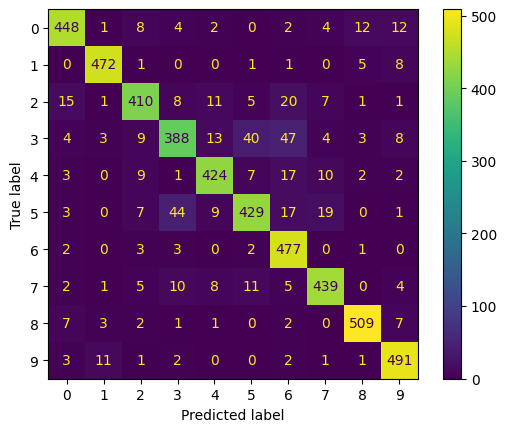

In [ ]:
pred = tf.nn.softmax(best_model.predict(X_val))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_val, axis=1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

In [ ]:
y_pred_proba = tf.nn.softmax(best_model.predict(X_val))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)

157/157 [==============================] - 0s 2ms/step
ROC_AUC Score: 0.99356488106194
Cohen_Kappa Score: 0.8859913758809667
F1 Score: 0.8969327704748981
Matthews Correlation Coefficient: 0.8863083332697981
Log Loss: 0.322773343799721
Accuracy: 0.8974


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Text(0, 0.5, 'Loss')

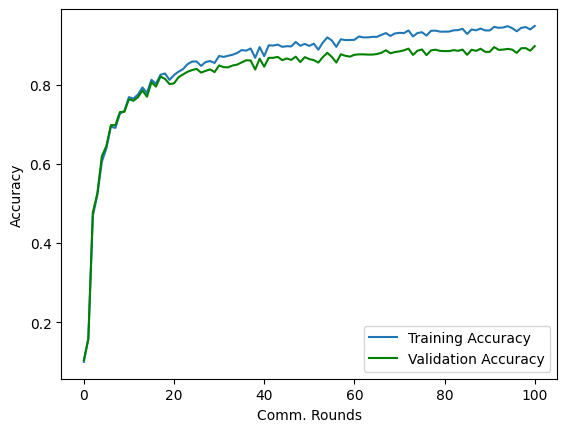

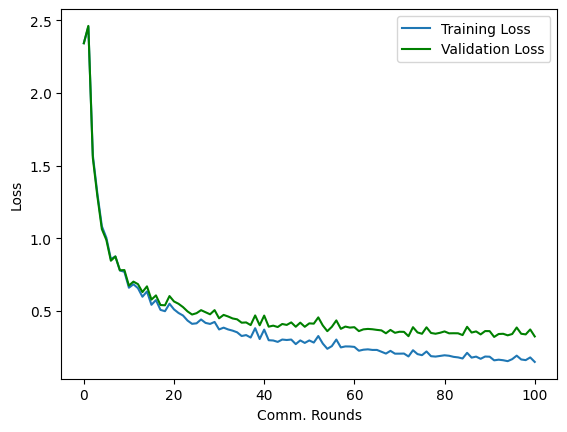

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = Tr_Accu
val_acc  = Accu
loss     = Tr_Loss
val_loss = Loss

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc, color = 'g')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss, color = 'g' )
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Loss')

# **Test Set Evaluation**

313/313 [==============================] - 1s 2ms/step


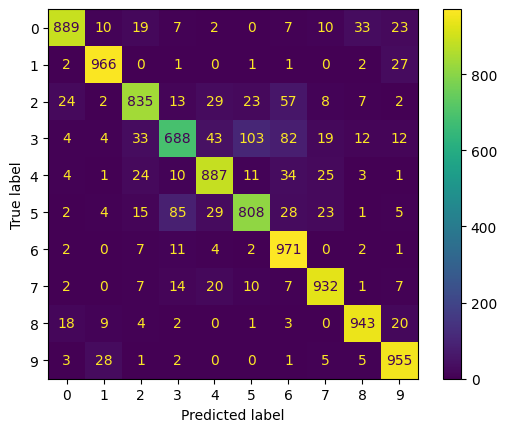

313/313 [==============================] - 1s 2ms/step
ROC_AUC Score: 0.9926336666666667
Cohen_Kappa Score: 0.8748888888888888
F1 Score: 0.8858713077208819
Matthews Correlation Coefficient: 0.8752571676087797
Log Loss: 0.34515239914992557
Accuracy: 0.8874


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
pred = tf.nn.softmax(best_model.predict(X_test))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_test, axis = 1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

y_pred_proba = tf.nn.softmax(best_model.predict(X_test))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)